In [1]:
import numpy as np
from cvxpy import *
import gurobipy
import copy
import networkx
import matplotlib.pyplot as plt
import itertools as it

# Skolkovo campus

In [4]:
n = 20

# F - flow
F = Variable(n,n)

Start = np.array([5,5,10,10,10,5,5,10,20,10,0,5,5,10,5,0,0,0,5,0])
Start_matrix = np.array([Start] * 20).T

# Required amount of earth array
b = 6 - Start

#Generating cost matrix
Cost = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        Cost[i][j] = np.sqrt((i / 5 - j / 5) ** 2 + (i % 5 - j % 5) ** 2) 

# trace(Cost.T * F) = trace(Cost * F) = sum Cost_ij * F_ij
objective = Minimize(trace(Cost * F))

# The first constraint is b_i + sum f_ij = sum f_ji, the third one - f_ij <= u_ij, the final one - f_ii = 0, obviously. 
constraints = [b + sum_entries(F, axis=1) - sum_entries(F.T, axis=1) == 0, 0 <= F, F <= Start_matrix, diag(F) == 0]
prob = Problem(objective, constraints)

prob.solve()
prob.value



Result = np.round(F.value)  # or gurobi solver
for i in range(n):
    for j in range(n):
        if Result[i,j] != 0:
            print i,'-----', int(Result[i,j]), '---->', j
print 'Cost', prob.value

1 ----- 1 ----> 0
2 ----- 2 ----> 1
2 ----- 1 ----> 5
2 ----- 1 ----> 6
3 ----- 4 ----> 10
4 ----- 1 ----> 9
4 ----- 1 ----> 14
4 ----- 1 ----> 18
4 ----- 1 ----> 19
7 ----- 2 ----> 10
7 ----- 2 ----> 11
8 ----- 4 ----> 12
8 ----- 5 ----> 15
8 ----- 3 ----> 16
8 ----- 2 ----> 17
9 ----- 3 ----> 14
9 ----- 2 ----> 19
11 ----- 1 ----> 15
12 ----- 3 ----> 16
13 ----- 4 ----> 17
14 ----- 3 ----> 19
Cost 95.4910638707


# Capacited facility location (BnB)

In [2]:
from numpy import random
from numpy import matlib
np.random.seed(1)

C = 20 # number of clients
clients = np.random.rand(2, C) #client positions
F = 15 #number of facilities
facilities = np.random.rand(2, F)

capacities = np.ones(F) * 4 #maximum number of clients per facility

dx = np.matlib.repmat(clients[0,:], F, 1) - np.matlib.repmat(facilities[0,:], C, 1).transpose()
dy = np.matlib.repmat(clients[1,:], F, 1) - np.matlib.repmat(facilities[1,:], C, 1).transpose()

assignment_costs = 3 * (dx * dx + dy * dy) #the assignment cost is the distance squared

opening_costs = np.ones(F)

## LP relaxation

In [3]:
X = Variable(F, C)
Y = Variable(F)

# sum c_ij x_ij = tr(C.T * X)
objective = Minimize(trace(assignment_costs.T * X) + opening_costs.T * Y)
constraints = [sum_entries(X, axis=1) <= capacities, # sum_j x_ji <= capacity_j
               sum_entries(X.T, axis=1) == 1,        # sum_i x_ji = 1
               0 <= X, X <= 1, 0 <= Y, Y <= 1]       # LP relaxation of x, y

for i in range(C):
    for j in range(F):
        constraints.append(X[j, i] <= Y[j])         # the final constraint x_ji <= y_j
        
prob = Problem(objective, constraints)

prob.solve()
print prob.value

X_sol = X.value
Y_sol = Y.value

6.14254499182


In [4]:
np.round(Y_sol, 4)

array([[ 0.    ],
       [ 0.5   ],
       [ 0.6667],
       [ 0.    ],
       [ 0.5   ],
       [ 0.    ],
       [ 0.    ],
       [ 0.4   ],
       [ 0.    ],
       [ 0.3333],
       [ 0.    ],
       [ 0.5   ],
       [ 0.    ],
       [ 0.1   ],
       [ 0.    ]])

In [5]:
def find_nonint_neartohalf(x):
    return np.argmin(np.abs(0.5 - x))

def find_nonint(x):
    if x != None:
        for i in range(len(x)):
            if int(x[i]) != x[i]:
                return i
    return None        

## Branch and Bound

In [7]:
X = Variable(F, C)
Y = Variable(F)

objective = Minimize(trace(assignment_costs.T * X) + opening_costs.T * Y)

# Our standard constraints
current_constraints = [sum_entries(X, axis=1) <= capacities, 
               sum_entries(X.T, axis=1) == np.ones(C),
               0 <= X, X <= 1, 0 <= Y, Y <= 1]

# Add constraints x_ji <= y_j
for i in range(C):
    for j in range(F):
        current_constraints.append(X[j, i] <= Y[j])
        
# Generatig two copies of constraints for different bounds
constraints_bound = [current_constraints, copy.copy(current_constraints)]

Y_current = Y_sol
X_current = X_sol
while find_nonint(Y_current) != None:
    current_solutions_y = []
    current_solutions_x = []
    current_obj_value = []
    
    # Find non integer value of Y
    index = find_nonint(Y_current)
    #index = find_nonint_neartohalf(Y_current)
    
    # Add constraint Y[index] = 0 to constraint array
    constraints_bound[0].append(Y[index] == 0)
    
    # Solve optimization problem
    prob1 = Problem(objective, constraints_bound[0])
    prob1.solve()
    current_solutions_y.append(Y.value) 
    current_solutions_x.append(X.value) 
    current_obj_value.append(prob1.value)
    
    #print current_obj_value[0]
    
    
    # Add constraint Y[index] = 1 to constraint array
    constraints_bound[1].append(Y[index] == 1)
    
    # Solve the second optimization problem
    prob2 = Problem(objective, constraints_bound[1])
    prob2.solve()
    current_solutions_y.append(Y.value) 
    current_solutions_x.append(X.value)
    current_obj_value.append(prob2.value)
    
    
    
    # Compare obtained values of objective function and choose the minimal one 
    result_index = current_obj_value.index(min(current_obj_value))
    
    # Save the corresponding constraints
    current_constraints = copy.copy(constraints_bound[result_index])
    constraints_bound = [current_constraints, copy.copy(current_constraints)]
    
    Y_current = np.round(current_solutions_y[result_index], 8)
    X_current = np.round(current_solutions_x[result_index], 8)
    opt_value_current = current_obj_value[result_index]


C:\Users\Evgeny\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [8]:
print 'Optimal value', opt_value_current
for j in range(F):
    for i in range(C):
        if X_current[j,i] != 0:
            print ("X[%s, %s]") % (j,i), '=',  int(X_current[j,i])
print ' '
print 'Other X are zero'
print ' '

for j in range(F):
    print ("Y[%s] =") % j, int(Y_current[j])

Optimal value 7.57111292334
X[5, 8] = 1
X[5, 10] = 1
X[5, 11] = 1
X[5, 15] = 1
X[7, 3] = 1
X[7, 14] = 1
X[7, 16] = 1
X[7, 19] = 1
X[9, 2] = 1
X[9, 6] = 1
X[9, 7] = 1
X[9, 18] = 1
X[11, 1] = 1
X[11, 9] = 1
X[11, 13] = 1
X[11, 17] = 1
X[13, 0] = 1
X[13, 4] = 1
X[13, 5] = 1
X[13, 12] = 1
 
Other X are zero
 
Y[0] = 0
Y[1] = 0
Y[2] = 0
Y[3] = 0
Y[4] = 0
Y[5] = 1
Y[6] = 0
Y[7] = 1
Y[8] = 0
Y[9] = 1
Y[10] = 0
Y[11] = 1
Y[12] = 0
Y[13] = 1
Y[14] = 0


We can see that after branch-n-bounding only $y$ variables we obtain the global optimum and integrality of all variables. So there is no necessity to branch-n-bound other variables.

# Students

## GUROBI solutions

For matrix1 opt value is 8.0


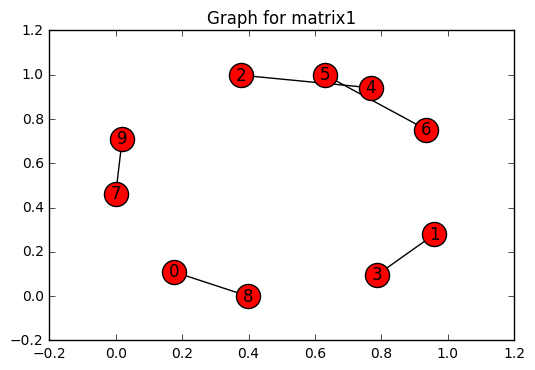

For matrix2 opt value is 18.0


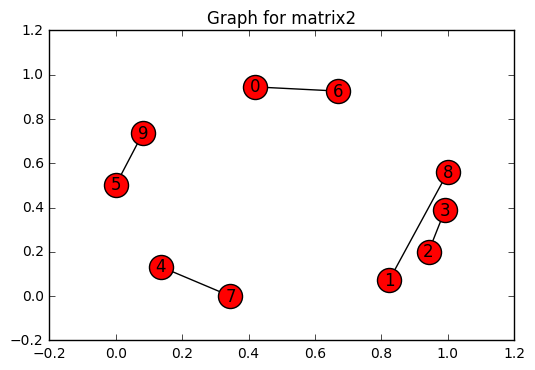

For matrix3 opt value is 10.0


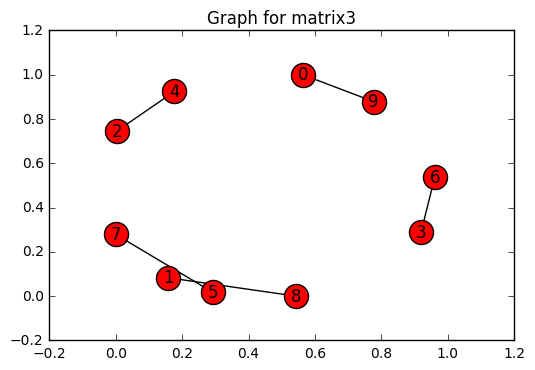

For matrix4 opt value is 32.703295738


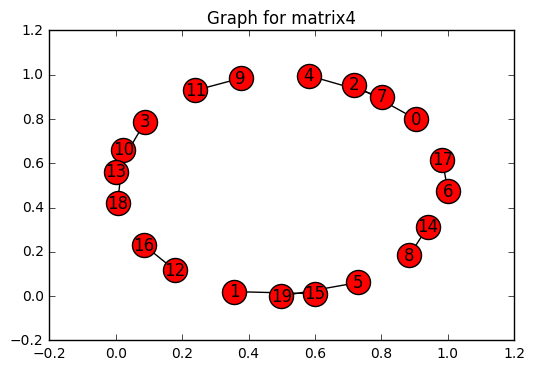

In [498]:
# ILP solving
matrix = [np.load('C:\Users\Evgeny\Opt. methods\matrix1.npy'),
          np.load('C:\Users\Evgeny\Opt. methods\matrix2.npy'),
          np.load('C:\Users\Evgeny\Opt. methods\matrix3.npy'),
          np.load('C:\Users\Evgeny\Opt. methods\matrix4.npy')]

X_gurobi = []

for i in range(4):
    Pref = matrix[i]
    n = len(Pref)
    
    X = Bool(n,n)

    objective = Maximize(trace(Pref * X))
    constraints = [sum_entries(X, axis=1) == 1, X.T == X, trace(X) == 0, 0 <= X]
    prob = Problem(objective, constraints)
    prob.solve(solver=GUROBI)
    X_bool = X.value
    print "For matrix%s" %(i+1),'opt value is', prob.value
    X_gurobi.append(X.value)
    # print X_gurobi[i]

    # Visualization

    G = networkx.from_numpy_matrix(X_bool)
    edges = G.edges(data=True)

    graph = networkx.Graph()
    graph.add_edges_from(edges)
    networkx.draw_networkx(graph)
    
    plt.title('Graph for matrix%s' %(i+1))
    plt.show()

## LP relaxation

After LP relaxation opt value for matrix1 is 9.99999999617


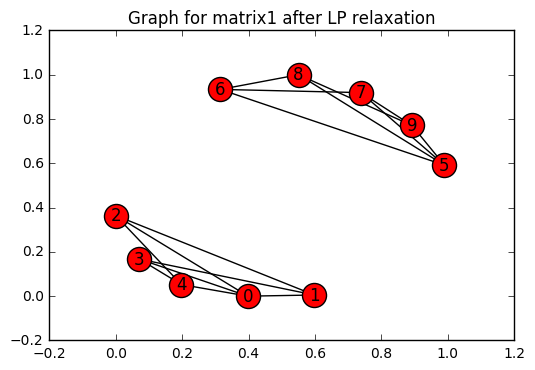

After LP relaxation opt value for matrix2 is 17.9999999837


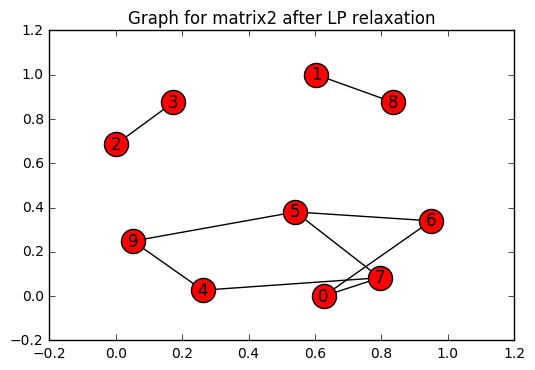

After LP relaxation opt value for matrix3 is 10.0


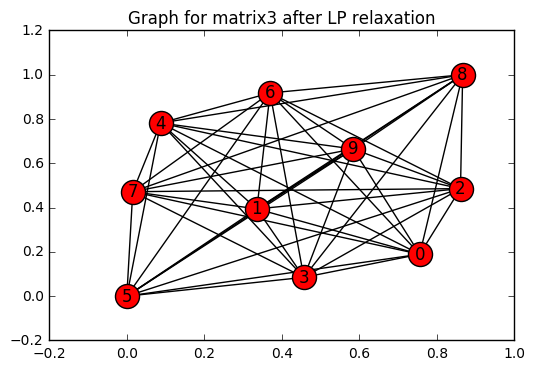

After LP relaxation opt value for matrix4 is 32.7493026457


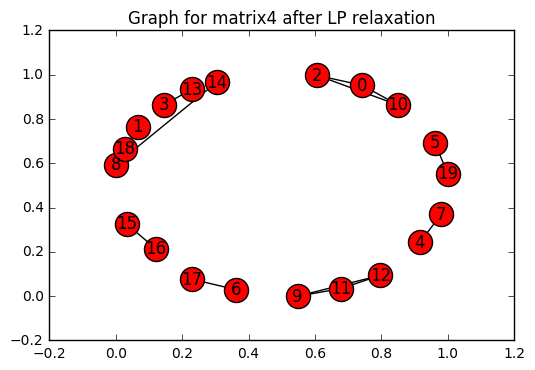

In [496]:
# LP relaxation

Graph_array = []

for i in range(4):
    Pref = matrix[i]
    n = len(Pref)
    
    X = Variable(n,n)

    objective = Maximize(trace(Pref * X))
    constraints = [sum_entries(X, axis=1) == 1, X.T == X, trace(X) == 0, 0 <= X, X <= 1]
    prob = Problem(objective, constraints)
    prob.solve()
    X_relax = X.value
    print "After LP relaxation opt value for matrix%s is" %(i+1), prob.value
    # print X.value

    # Visualization
    G = networkx.from_numpy_matrix(np.round(X_relax, 7))
    edges = G.edges(data=True)

    graph2 = networkx.Graph()
    graph2.add_edges_from(edges)
    networkx.draw_networkx(graph2)
    
    Graph_array.append(graph2)
    
    plt.title('Graph for matrix%s after LP relaxation' %(i+1))
    plt.show()

## Branch and cutting alg.

In [500]:
X_bnc = []


for i in range(4):
    
    Pref = matrix[i]
    n = len(Pref)
    X = Variable(n,n)
    
    objective = Maximize(trace(Pref * X))
    constraints_bnc = [sum_entries(X, axis=1) == 1, X.T == X, trace(X) == 0,  0 <= X, X <= 1]
    
    #Find all cliques in solution oracle of LP relaxation problems
    cliques = networkx.find_cliques(Graph_array[i])
    for clique in cliques:
        if len(clique) > 2:
            #print clique
            # Adding corresponding to cliques constraints
            # Sum of corresponding variables <= 1
            constraints_bnc.append(sum(X[pair[0], pair[1]] for pair in it.combinations(clique, 2)) <= 1)

    prob = Problem(objective, constraints_bnc)

    prob.solve()
    if X.value != None:
        X_bnc.append(np.round(X.value, 7))
    else:
        X_bnc.append(None)

    print "For the matrix%s after branch and cutting opt value is" %(i+1), prob.value
    # print X_bnc[i]

For the matrix1 after branch and cutting opt value is 10.0000000001
For the matrix2 after branch and cutting opt value is 17.9999999837
For the matrix3 after branch and cutting opt value is -inf
For the matrix4 after branch and cutting opt value is 32.7032957345


C:\Users\Evgeny\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


We can see that only in the case of $matrix4$ branch-n-cutting algorithm gives the global optimum and integer solution.

Here are all values for all problems for GUROBI, LP relaxation and Branch-n-Cutting:

* matrix1: 8.0; 9.99999999617 nonint solution; 10.0000000001 nonint solution
* matrix2: 18.0; 17.9999999837 nonint solution; 18.0 nonint solution
* matrix3: 10.0; 10.0 nonint solution; 10.0 nonint solution
* matrix4: 32.703295738; 32.7493026457 nonint solution; 32.7493026417 int solution

In [499]:
print 'BnC solution for matrix4'
print X_bnc[3]

BnC solution for matrix4
[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
   0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
   0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1